### First read data from the disk

In [7]:
import pandas as pd
import numpy as np
import cv2
import copy

directory = 'training_data1'
df = pd.read_csv('./'+directory+'/driving_log.csv')
df.columns = ['center','left','right','steering','throttle','brake','speed']


df_non_zero_steering = df.loc[lambda df: df.steering != 0, :].copy()
df_non_zero_steering = df_non_zero_steering.reset_index(drop = True)
nb_training_data = df_non_zero_steering.center.shape[0]
print (nb_training_data)

X_training =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)
X_training_left =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)
X_training_right =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)


# gathering data from center camera
index = 0
for line in range(nb_training_data):
    # for center camera
    source_path = df_non_zero_steering.center[line]
    filename = source_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training[index] = image

    # for left camera
    left_cam_path = df_non_zero_steering.left[line]
    filename = left_cam_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training_left[index] = image
    
    # for right camera
    right_cam_path = df_non_zero_steering.right[line]
    filename = right_cam_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training_right[index] = image

    # increase index
    index+=1

    
# read label from df
lable_y = df_non_zero_steering.as_matrix(columns=['steering'])
y_train = lable_y[:,0]

# add a shift manaully
y_train_left = np.copy(y_train)
y_train_left = y_train_left + 0.1
y_train_right = np.copy(y_train)
y_train_right = y_train_right - 0.1
# 

X_train_initial_aug =  np.vstack( (X_training,X_training_left, X_training_right) )
y_train_initial_aug =  np.concatenate( (y_train, y_train_left, y_train_right ) )



3905


In [8]:
df_non_zero_steering

,center,left,right,steering,throttle,brake,speed
0,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.025849,0.197771,0.0,1.850193
1,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.016204,0.207378,0.0,2.015046
2,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.016204,0.207378,0.0,2.230092
3,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.006559,0.197771,0.0,2.456750
4,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.025849,0.092088,0.0,3.187066
5,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.045139,0.092088,0.0,3.282140
6,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.045139,0.092088,0.0,3.363827
7,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.045139,0.092088,0.0,3.424090
8,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.054784,0.092088,0.0,3.502718
9,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.083719,0.092088,0.0,3.580061


### Visualize training data

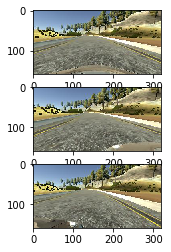

In [9]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
random_image = random.randint(0 , X_training.shape[0])   
#plt.figure( figsize =(100,100))
plt.subplot(3, 1, 1)
plt.imshow( cv2.cvtColor(X_training[random_image], cv2.COLOR_BGR2RGB) )
plt.subplot(3, 1, 2)
plt.imshow( cv2.cvtColor(X_training_left[random_image], cv2.COLOR_BGR2RGB) )
plt.subplot(3, 1, 3)
plt.imshow( cv2.cvtColor(X_training_right[random_image], cv2.COLOR_BGR2RGB) )


In [ ]:
## use left and right image to train on non zero datas 
df.loc[lambda df: df.steering != 0, :]



### Data augmentation

In [10]:
X_training_flip = np.zeros([y_train_initial_aug.shape[0], 160 , 320 , 3 ], dtype=np.uint8)
for i in range(y_train_initial_aug.shape[0]):
    X_training_flip[i] =  np.fliplr(X_train_initial_aug[i])
y_train_flip = -y_train_initial_aug


In [11]:
y_train_flip.shape

(11715,)

In [12]:
# stack training data
X_train_aug =  np.vstack( (X_train_initial_aug,X_training_flip) )
y_train_aug =  np.concatenate( (y_train_initial_aug, y_train_flip))

In [ ]:
df

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D

i_shape = (160, 320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=i_shape ))
model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,3)))

# conv_net
model.add(Conv2D( 6, 5, 5, activation='relu', input_shape = i_shape))
model.add(Conv2D( 6, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
########################################################################
# conv_net
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#########################################################################
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse',optimizer='adam')
model.fit(X_training, y_train, validation_split = 0.2, shuffle=True)
model.save('first_model.h5')




Using TensorFlow backend.


Train on 3124 samples, validate on 781 samples
Epoch 1/10
  64/3124 [..............................] - ETA: 307s - loss: 0.0167